In [1]:
import sys

COMMON_DIR = "/mnt/d/github/computer_vision/books/generative_deep_learning/pytorch/common"
if COMMON_DIR not in sys.path:
    sys.path.append(COMMON_DIR)

from common.datasets import get_train_loader, get_test_loader
from common.utils import set_seed, plot_images
from common.trainer import fit, evaluate, predict

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as T

In [3]:
## Hyperparameters

IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 300
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

SEED = 42
set_seed(SEED)

In [4]:
## Data Loading
from common.datasets import LegoBricks

root_dir = "/mnt/d/datasets/lego_bricks"
transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=T.InterpolationMode.BILINEAR),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5]),
])

train_loader = get_train_loader(dataset=LegoBricks(root_dir, "train", transform=transform), batch_size=BATCH_SIZE)
test_loader = get_test_loader(dataset=LegoBricks(root_dir, "test", transform=transform), batch_size=64)

batch = next(iter(train_loader))
images, labels = batch["image"], batch["label"]
print(f"\ntrain dataset: {len(train_loader.dataset)}, dataloader: {len(train_loader)}")
print(f"train images: {images.shape}, {images.dtype}, {images.min()}, {images.max()}")
print(f"train labels: {labels.shape}, {labels.dtype}, {labels.min()}, {labels.max()}")

batch = next(iter(test_loader))
images, labels = batch["image"], batch["label"]
print(f"\ntest dataset: {len(test_loader.dataset)}, dataloader: {len(test_loader)}")
print(f"test  images: {images.shape}, {images.dtype}, {images.min()}, {images.max()}")
print(f"test  labels: {labels.shape}, {labels.dtype}, {labels.min()}, {labels.max()}")


train dataset: 32000, dataloader: 250
train images: torch.Size([128, 1, 64, 64]), torch.float32, -1.0, 0.27843141555786133
train labels: torch.Size([128]), torch.int64, 0, 45

test dataset: 8000, dataloader: 125
test  images: torch.Size([64, 1, 64, 64]), torch.float32, -1.0, 0.27843141555786133
test  labels: torch.Size([64]), torch.int64, 0, 44


In [5]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, momentum=0.9),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, momentum=0.9),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.3)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512, momentum=0.9),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.3)
        )
        self.conv5 = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(-1, 1)
        return torch.sigmoid(x)

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, out_channels=3):
        super().__init__()
        self.latent_dim = latent_dim

        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512, momentum=0.9),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, momentum=0.9),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, momentum=0.9),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, momentum=0.9),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.deconv5 = nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1, bias=False)

    def forward(self, z):
        x = z.view(-1, z.size(1), 1, 1)  # (B, Z_DIM) -> (B, Z_DIM, 1, 1)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        x = self.deconv5(x)
        return torch.tanh(x)
    
    @torch.no_grad()
    def pred_step(self, z):
        latent = batch["image"].to(next(self.parameters()).device)
        images = self.forward(latent)
        return dict(image=images)

In [7]:
def create_images(generator, z_sample):
    device = next(generator.parameters()).device
    z_tensor = torch.tensor(z_sample).float().to(device)
    with torch.no_grad():
        images = generator(z_tensor).cpu().numpy().squeeze()

    images = (images + 1) / 2
    images = np.clip(images, 0, 1)
    return images

In [8]:
from models.gan import GAN

discriminator = Discriminator(in_channels=1)
generator = Generator(latent_dim=Z_DIM, out_channels=1)
gan = GAN(discriminator, generator)
z_sample = np.random.normal(size=(20, Z_DIM))

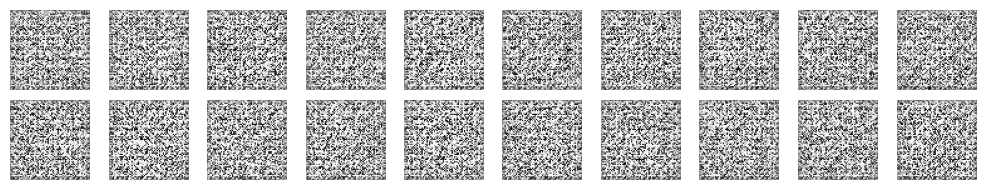

[  1/2] real_loss:0.009, fake_loss:0.013, gen_loss:7.742, real_acc:0.997, fake_acc:0.995, gen_acc:0.001                                                  
[  2/2] real_loss:0.000, fake_loss:0.000, gen_loss:9.802, real_acc:1.000, fake_acc:1.000, gen_acc:0.000                                                  


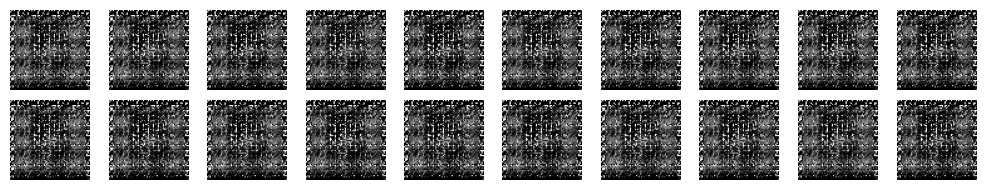

[  1/2] real_loss:0.325, fake_loss:0.333, gen_loss:6.371, real_acc:0.861, fake_acc:0.860, gen_acc:0.073                                                  
[  2/2] real_loss:0.552, fake_loss:0.536, gen_loss:1.689, real_acc:0.730, fake_acc:0.732, gen_acc:0.127                                                  


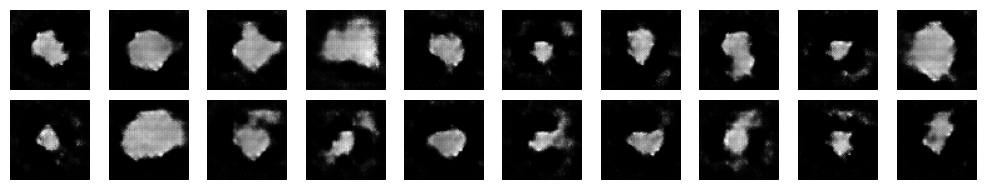

[  1/2] real_loss:0.484, fake_loss:0.510, gen_loss:1.953, real_acc:0.770, fake_acc:0.742, gen_acc:0.083                                                  
[  2/2] real_loss:0.502, fake_loss:0.517, gen_loss:1.702, real_acc:0.754, fake_acc:0.728, gen_acc:0.101                                                  


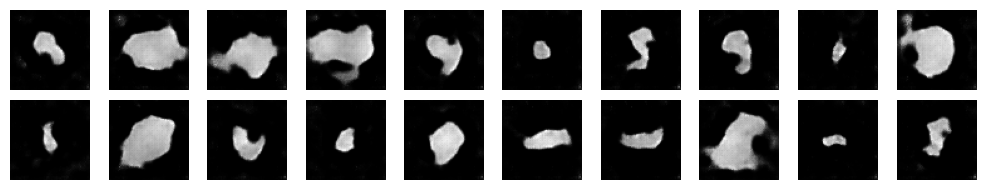

[  1/2] real_loss:0.441, fake_loss:0.472, gen_loss:1.984, real_acc:0.795, fake_acc:0.760, gen_acc:0.068                                                  
[  2/2] real_loss:0.427, fake_loss:0.461, gen_loss:2.018, real_acc:0.804, fake_acc:0.764, gen_acc:0.078                                                  


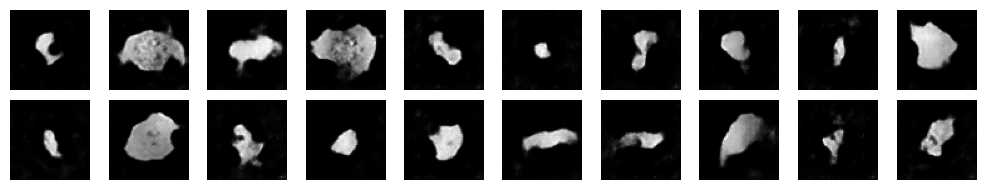

[  1/2] real_loss:0.455, fake_loss:0.480, gen_loss:1.872, real_acc:0.783, fake_acc:0.746, gen_acc:0.109                                                  
[  2/2] real_loss:0.431, fake_loss:0.451, gen_loss:1.947, real_acc:0.804, fake_acc:0.774, gen_acc:0.103                                                  


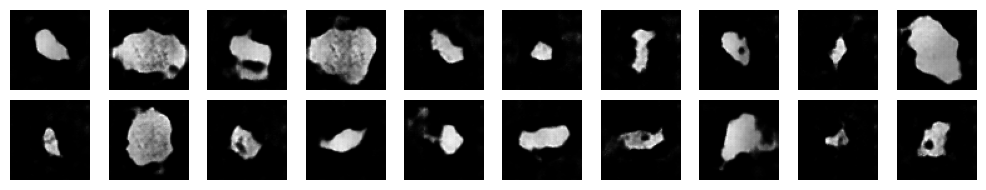

In [9]:
images = create_images(generator, z_sample)
plot_images(*images, ncols=10, xunit=1, yunit=1)

for _ in range(5):
    history = fit(gan, train_loader, num_epochs=2)
    images = create_images(generator, z_sample)
    plot_images(*images, ncols=10, xunit=1, yunit=1)

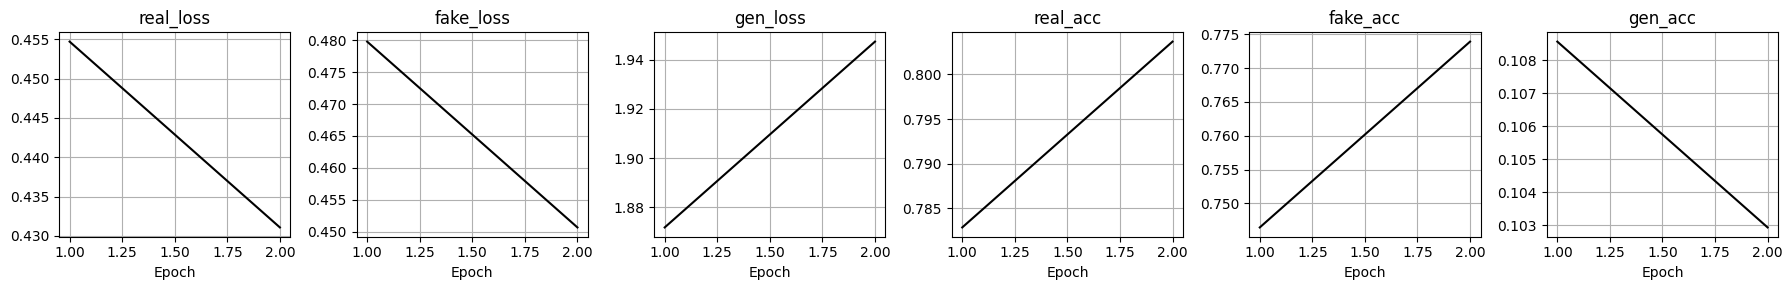

In [10]:
from common.utils import plot_history

plot_history(history["train"])